<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch14_cnn_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 14 — Deep Computer Vision Using Convolutional Neural Networks

## 1) Summary
In this chapter, I focus on **Convolutional Neural Networks (CNNs)** for computer vision and reproduce the core workflows using Keras/TensorFlow.

What I implement and explain in this notebook:
- Why CNNs work better than plain MLPs for images (local connectivity + parameter sharing).
- How convolution layers transform images into **feature maps** (filters/kernels, stride, padding).
- Pooling and downsampling (MaxPool) and why it helps (compute + translation robustness).
- Building and training a CNN on **Fashion MNIST** (baseline → improved versions).
- Practical techniques that make CNN training more reliable:
  - Batch Normalization,
  - Dropout,
  - data augmentation (as Keras preprocessing layers).
- Inspecting intermediate activations (feature maps) to understand what the CNN learns.
- Transfer learning for vision using a pretrained CNN (MobileNetV2) on **CIFAR-10**:
  - freeze base → train head → fine-tune last layers.

My end result:
I have runnable CNN notebooks that follow a clean workflow:
**dataset → baseline model → improvements → evaluation → interpretation**.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 2) Concept Notes (CNNs in practice)

### 2.1 Why not just flatten images and use Dense layers?
A fully connected MLP treats every pixel as independent. For images, that causes:
- too many parameters (slow, overfitting risk),
- no built-in notion of locality (edges, textures),
- less translation robustness.

### 2.2 CNN core assumptions
CNNs build in two image-friendly biases:
- **Local connectivity**: each neuron looks at a small patch (receptive field).
- **Parameter sharing**: the same filter is applied across the image → fewer parameters.

This makes CNNs:
- more data-efficient,
- better at learning spatial features,
- and easier to scale to deeper architectures.

### 2.3 Convolution layer essentials
A Conv2D layer is defined by:
- number of filters (output channels),
- kernel size (e.g., 3×3),
- stride (step size),
- padding ("same" vs "valid").

If input size is (H, W), kernel size K, stride S, padding P (per side),
output size is roughly:
- H_out = floor((H + 2P − K)/S) + 1
- W_out = floor((W + 2P − K)/S) + 1

### 2.4 Pooling
Pooling downsamples feature maps (e.g., MaxPooling2D).
It reduces computation and adds a little translation robustness, but it also discards information,
so modern architectures sometimes replace pooling with strided convolutions.

### 2.5 Typical CNN block
A common pattern:
Conv2D → (BatchNorm) → ReLU → (Pool)
Repeated multiple times, then:
Flatten/GlobalAvgPool → Dense → Output

### 2.6 Transfer Learning
Transfer learning is common in vision:
- load a pretrained backbone (ImageNet),
- freeze it,
- train a small classifier head,
- optionally fine-tune top layers with a small learning rate.

In [2]:
def plot_history(history, title):
    df = pd.DataFrame(history.history)
    cols_loss = [c for c in df.columns if "loss" in c]
    cols_acc = [c for c in df.columns if "acc" in c]
    if cols_loss:
        df[cols_loss].plot(figsize=(8, 4), grid=True, title=title + " — loss")
        plt.show()
    if cols_acc:
        df[cols_acc].plot(figsize=(8, 4), grid=True, title=title + " — accuracy")
        plt.ylim(0, 1)
        plt.show()

def show_images(images, labels=None, class_names=None, n=12, title=None):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(3, 4, i+1)
        img = images[i]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
        plt.imshow(img, cmap="binary" if img.ndim == 2 else None)
        if labels is not None and class_names is not None:
            plt.title(class_names[int(labels[i])])
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Part A — CNN on Fashion MNIST

## 3) Load dataset
Fashion MNIST:
- 28×28 grayscale images
- 10 classes
- good for fast CNN experiments

Steps:
1. Load dataset
2. Scale pixel values to [0, 1]
3. Add channel dimension (28,28) → (28,28,1)
4. Create train/validation split

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Add channel dimension
X_train_full = X_train_full[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Split train/valid
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

X_train.shape, X_valid.shape, X_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

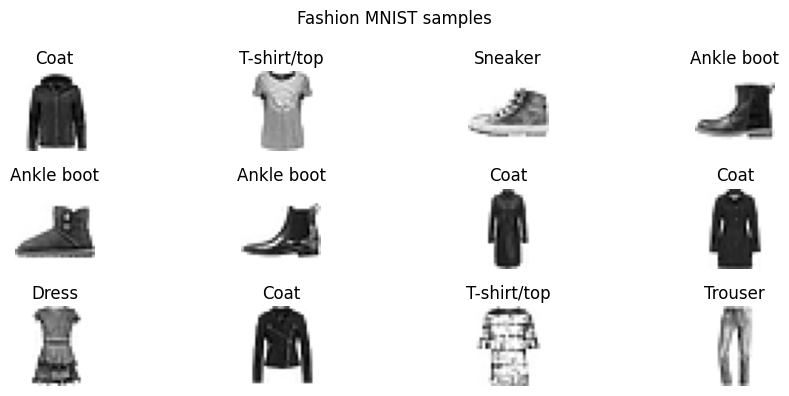

In [4]:
show_images(X_train[:12], y_train[:12], class_names, n=12, title="Fashion MNIST samples")

## 4) Baseline CNN model
Baseline architecture:
- Conv(32, 3×3) + ReLU
- MaxPool(2×2)
- Conv(64, 3×3) + ReLU
- MaxPool(2×2)
- Flatten
- Dense(128) + ReLU
- Dropout(0.3)
- Dense(10) + Softmax

This is not a “state-of-the-art” CNN; it is a clean baseline that is easy to interpret and runs fast.

In [5]:
baseline_cnn = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),

    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

baseline_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Compile + Train
I use:
- optimizer: Adam (strong default)
- loss: sparse categorical cross-entropy (integer labels)
- metric: accuracy

Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7444 - loss: 0.7092 - val_accuracy: 0.8856 - val_loss: 0.3147
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8790 - loss: 0.3349 - val_accuracy: 0.9038 - val_loss: 0.2631
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8977 - loss: 0.2786 - val_accuracy: 0.9130 - val_loss: 0.2357
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9110 - loss: 0.2462 - val_accuracy: 0.9156 - val_loss: 0.2253
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9176 - loss: 0.2239 - val_accuracy: 0.9206 - val_loss: 0.2183
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9246 - loss: 0.2007 - val_accuracy: 0.9210 - val_loss: 0.2165
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9314 - loss: 0.1827 - val_accuracy: 0.9238 - val_loss: 0.2057
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9367 - loss: 0.1684 - val_accuracy: 0

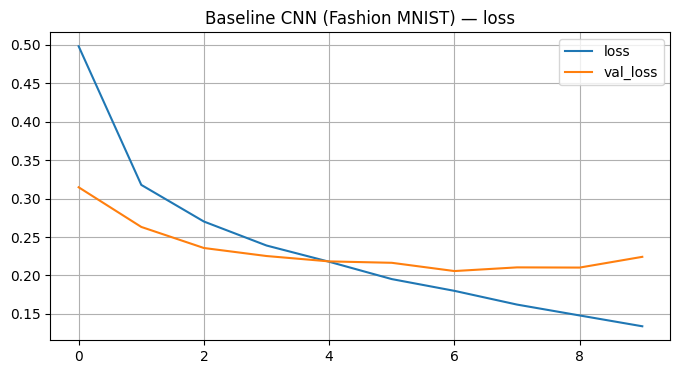

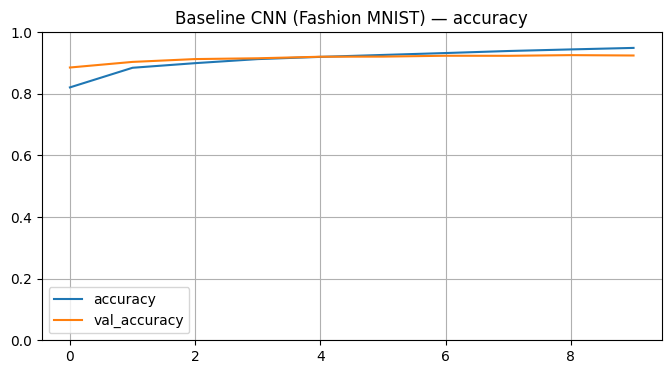

In [6]:
baseline_cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

hist_base = baseline_cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    verbose=1
)

plot_history(hist_base, "Baseline CNN (Fashion MNIST)")

## 6) Evaluate on test set
This is the final performance snapshot for the baseline model.

In [7]:
test_loss, test_acc = baseline_cnn.evaluate(X_test, y_test, verbose=0)
test_loss, test_acc

(0.2527058720588684, 0.9160000085830688)

## 7) Quick prediction check
I run inference on a few samples to confirm the model’s output is reasonable.

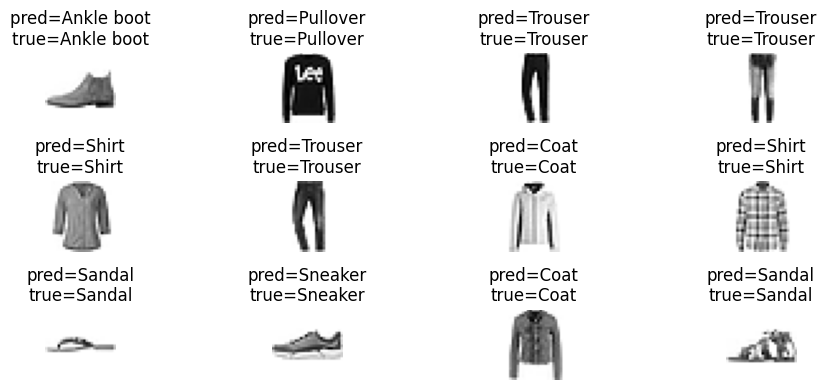

In [8]:
X_new = X_test[:12]
proba = baseline_cnn.predict(X_new, verbose=0)
y_pred = np.argmax(proba, axis=1)

plt.figure(figsize=(10, 4))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_new[i].squeeze(-1), cmap="binary")
    plt.title(f"pred={class_names[y_pred[i]]}\ntrue={class_names[y_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Part B — Improving robustness (BatchNorm + Data Augmentation)

## 8) Why Batch Normalization?
BatchNorm usually helps training stability by normalizing intermediate activations and learning scale/shift.
Common pattern:
Conv → BatchNorm → ReLU

## 9) Why Data Augmentation?
Data augmentation increases effective dataset diversity:
- small random flips/rotations/zooms
- encourages robustness to small spatial variations
- reduces overfitting

Here I implement augmentation using Keras preprocessing layers so it stays inside the model graph.

In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")

aug_bn_cnn = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    data_augmentation,

    keras.layers.Conv2D(32, 3, padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 3, padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 3, padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation="softmax")
])

aug_bn_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,250 (399.41 KB)

 Trainable params: 101,802 (397.66 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6146 - loss: 1.0774 - val_accuracy: 0.7264 - val_loss: 0.7646
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7959 - loss: 0.5721 - val_accuracy: 0.8238 - val_loss: 0.4923
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8215 - loss: 0.5084 - val_accuracy: 0.7988 - val_loss: 0.5796
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8342 - loss: 0.4657 - val_accuracy: 0.8292 - val_loss: 0.4935
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8426 - loss: 0.4401 - val_accuracy: 0.8436 - val_loss: 0.4640
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8464 - loss: 0.4323 - val_accuracy: 0.8604 - val_loss: 0.3806
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8587 - loss: 0.4014 - val_accuracy: 0.8534 - val_loss: 0.4039
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8601 - loss: 0.3936 - val_accuracy: 0

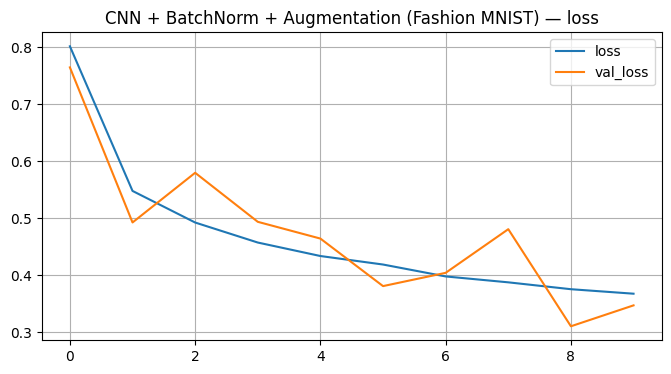

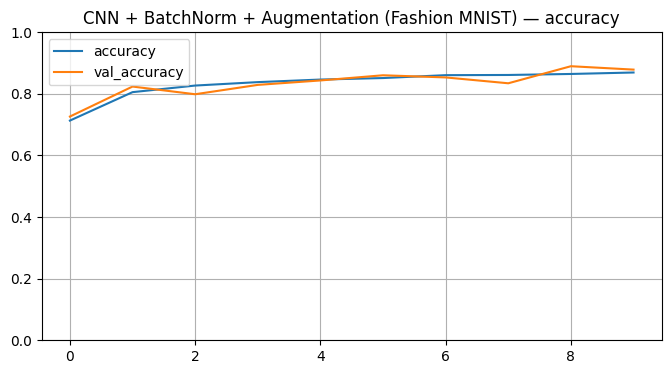

In [10]:
aug_bn_cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

hist_aug = aug_bn_cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    verbose=1
)

plot_history(hist_aug, "CNN + BatchNorm + Augmentation (Fashion MNIST)")

In [11]:
aug_test_loss, aug_test_acc = aug_bn_cnn.evaluate(X_test, y_test, verbose=0)
aug_test_loss, aug_test_acc

(0.39765727519989014, 0.8607000112533569)

Interpretation note:
- If augmentation improves validation/test accuracy and reduces the train/val gap, it supports the idea that the model generalizes better.
- If performance drops, the augmentation might be too strong or the model might need longer training.

# Part C — Inspect intermediate activations (feature maps)

## 10) Why inspect feature maps?
This is a quick sanity check to understand what the CNN learns:
- early layers often detect edges/contrasts,
- deeper layers respond to more complex patterns.

This is not a formal interpretability method, but it helps connect the theory to what the network is doing.

In [12]:
# Pick a convolution layer to inspect (first Conv2D layer in baseline model)
layer_names = [layer.name for layer in baseline_cnn.layers]
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dropout',
 'dense_1']

In [17]:
baseline_cnn.build((None, 28, 28, 1))

conv1 = next(layer for layer in baseline_cnn.layers if isinstance(layer, keras.layers.Conv2D))
activation_model = keras.Model(inputs=baseline_cnn.inputs, outputs=conv1.output)

sample = X_test[:1]
activations = activation_model.predict(sample, verbose=0)
activations.shape

(1, 28, 28, 32)

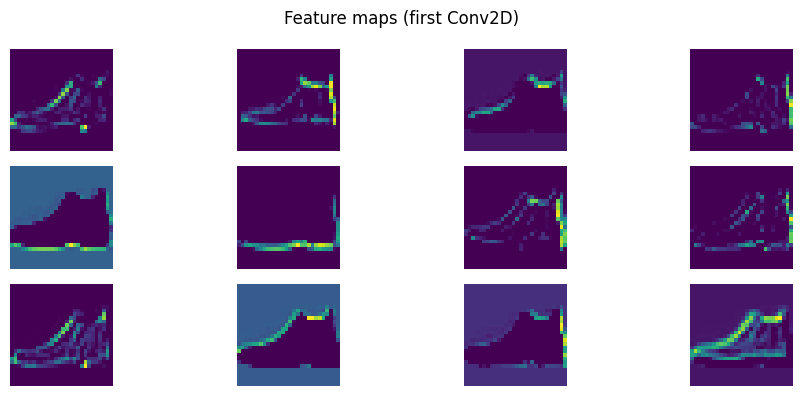

In [18]:
# Visualize a few feature maps
n_maps = min(12, activations.shape[-1])
plt.figure(figsize=(10, 4))
for i in range(n_maps):
    plt.subplot(3, 4, i+1)
    plt.imshow(activations[0, :, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle("Feature maps (first Conv2D)")
plt.tight_layout()
plt.show()

# Part D — Transfer Learning (MobileNetV2 on CIFAR-10)

## 11) Why transfer learning for vision?
Pretrained CNN backbones (trained on ImageNet) often learn generic visual features (edges → textures → parts).
Even if my target dataset is different, these features can be reused.

Workflow I follow:
1. Load CIFAR-10
2. Resize images to a size MobileNetV2 accepts (e.g., 96×96)
3. Use `mobilenet_v2.preprocess_input`
4. Build model: pretrained base (frozen) + new classifier head
5. Train head
6. Fine-tune top layers with a small learning rate (optional)

Note:
- Pretrained weights download requires internet access.
- If weights cannot be downloaded, I fall back to `weights=None` to keep the notebook runnable (but accuracy will likely be lower).

In [19]:
(cifar_X_train, cifar_y_train), (cifar_X_test, cifar_y_test) = keras.datasets.cifar10.load_data()
cifar_y_train = cifar_y_train.squeeze().astype(np.int32)
cifar_y_test = cifar_y_test.squeeze().astype(np.int32)

# Train/valid split
cifar_X_valid, cifar_X_train = cifar_X_train[:5000], cifar_X_train[5000:]
cifar_y_valid, cifar_y_train = cifar_y_train[:5000], cifar_y_train[5000:]

cifar_X_train.shape, cifar_X_valid.shape, cifar_X_test.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

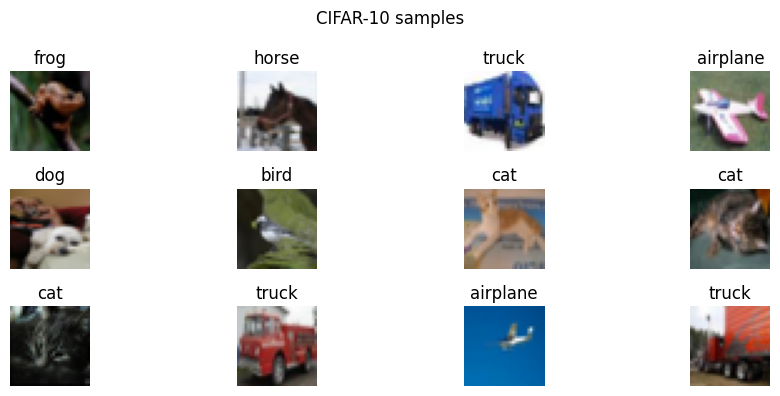

In [20]:
cifar_class_names = ["airplane","automobile","bird","cat","deer",
                     "dog","frog","horse","ship","truck"]
show_images(cifar_X_train[:12], cifar_y_train[:12], cifar_class_names, n=12, title="CIFAR-10 samples")

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 96

def resize_and_preprocess(X, y):
    X = tf.image.resize(X, (IMG_SIZE, IMG_SIZE))
    X = preprocess_input(X)  # scales to MobileNetV2 expected range
    return X, y

batch_size = 64

cifar_train_ds = tf.data.Dataset.from_tensor_slices((cifar_X_train, cifar_y_train))
cifar_train_ds = cifar_train_ds.shuffle(10000, seed=42).batch(batch_size).map(resize_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

cifar_valid_ds = tf.data.Dataset.from_tensor_slices((cifar_X_valid, cifar_y_valid))
cifar_valid_ds = cifar_valid_ds.batch(batch_size).map(resize_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

cifar_test_ds = tf.data.Dataset.from_tensor_slices((cifar_X_test, cifar_y_test))
cifar_test_ds = cifar_test_ds.batch(batch_size).map(resize_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

for Xb, yb in cifar_train_ds.take(1):
    print(Xb.shape, yb.shape, tf.reduce_min(Xb).numpy(), tf.reduce_max(Xb).numpy())

(64, 96, 96, 3) (64,) -1.0 1.0


In [22]:
# Load pretrained base if possible
try:
    base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
    pretrained_used = True
except Exception as e:
    base = MobileNetV2(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    pretrained_used = False

base.trainable = False
print("Pretrained ImageNet weights:", pretrained_used)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Pretrained ImageNet weights: True


In [23]:
inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
tl_model = keras.Model(inputs, outputs)

tl_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

tl_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.6963 - loss: 0.9235 - val_accuracy: 0.8444 - val_loss: 0.4514
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8409 - loss: 0.4624 - val_accuracy: 0.8614 - val_loss: 0.4147
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8508 - loss: 0.4303 - val_accuracy: 0.8620 - val_loss: 0.4106
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8559 - loss: 0.4127 - val_accuracy: 0.8688 - val_loss: 0.4036
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8638 - loss: 0.3998 - val_accuracy: 0.8676 - val_loss: 0.4045


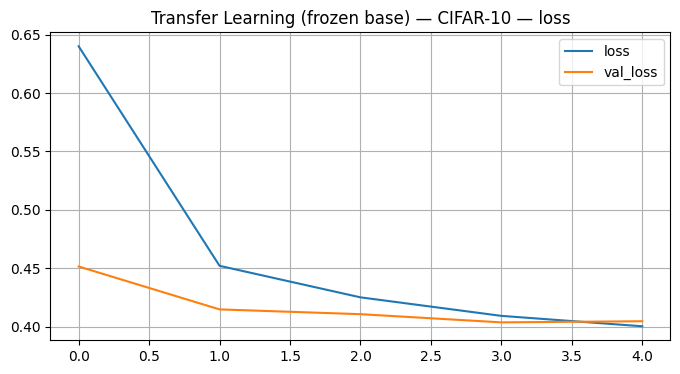

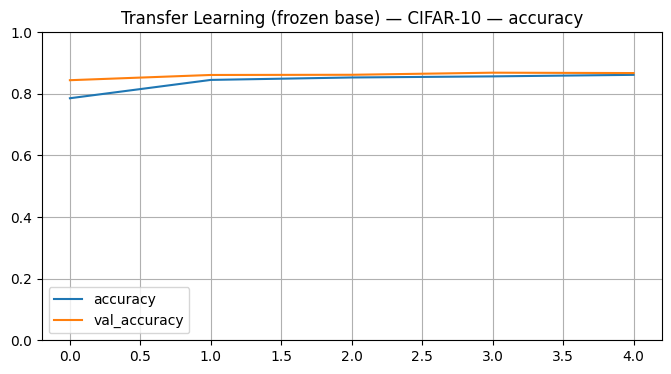

In [24]:
hist_tl = tl_model.fit(
    cifar_train_ds,
    validation_data=cifar_valid_ds,
    epochs=5,
    verbose=1
)

plot_history(hist_tl, "Transfer Learning (frozen base) — CIFAR-10")

In [25]:
tl_test_loss, tl_test_acc = tl_model.evaluate(cifar_test_ds, verbose=0)
tl_test_loss, tl_test_acc, pretrained_used

(0.4153781235218048, 0.8586999773979187, True)

## 12) Fine-tuning (optional)
If pretrained weights are available, fine-tuning often improves performance:
- unfreeze a few top layers,
- use a much smaller learning rate,
- train a few more epochs.

If weights were not available, fine-tuning is still possible but usually less useful.

Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.8701 - loss: 0.3719 - val_accuracy: 0.8798 - val_loss: 0.3539
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8949 - loss: 0.3040 - val_accuracy: 0.8872 - val_loss: 0.3344
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9091 - loss: 0.2589 - val_accuracy: 0.8894 - val_loss: 0.3264


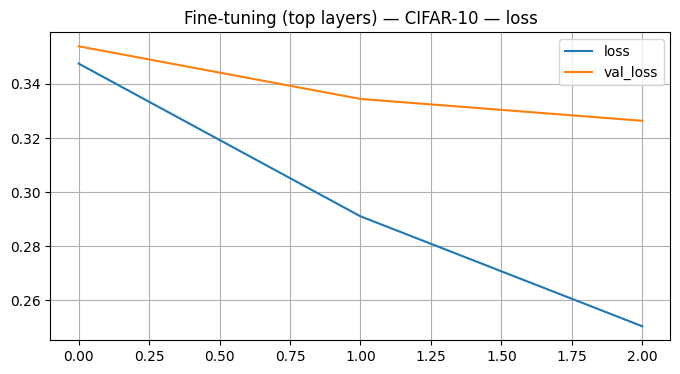

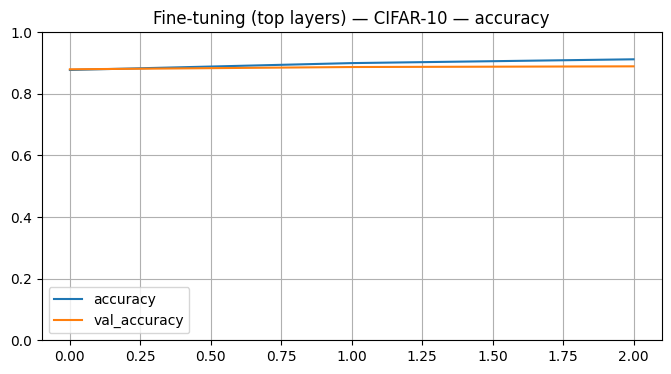

In [26]:
# Unfreeze last N layers for fine-tuning (keep BatchNorm layers typically frozen in many recipes)
N = 30
for layer in base.layers[:-N]:
    layer.trainable = False
for layer in base.layers[-N:]:
    # Many workflows keep BatchNorm frozen; we follow that rule of thumb
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

tl_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

hist_ft = tl_model.fit(
    cifar_train_ds,
    validation_data=cifar_valid_ds,
    epochs=3,
    verbose=1
)

plot_history(hist_ft, "Fine-tuning (top layers) — CIFAR-10")

In [27]:
ft_test_loss, ft_test_acc = tl_model.evaluate(cifar_test_ds, verbose=0)
ft_test_loss, ft_test_acc

(0.33852943778038025, 0.8852999806404114)

## 13) Takeaways
- CNNs exploit locality and parameter sharing to learn visual features efficiently.
- Convolutions produce feature maps; padding/stride control spatial resolution.
- Pooling/downsampling reduces compute and adds some robustness.
- BatchNorm + dropout + data augmentation are practical tools to improve training and generalization.
- Inspecting feature maps can connect “filters learn edges/textures” with actual model behavior.
- Transfer learning is a standard approach in vision:
  - freeze pretrained base → train head → fine-tune top layers with a small learning rate.

## 14) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 14.
- TensorFlow/Keras docs: Conv2D, MaxPooling2D, BatchNormalization, preprocessing layers, MobileNetV2.